# Referencias
Duffie, J. A., & Beckman, W. A. (2013). Solar Engineering of Thermal Processes (4th ed.). Wiley.


In [1]:
import pvlib
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from iertools.read import read_epw
from dateutil.parser import parse
import locale
from matplotlib.dates import ConciseDateFormatter, AutoDateLocator
import pytz
from ehtools.diatipico import *

locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

timezone = pytz.timezone('America/Mexico_City')
plt.rcParams['timezone'] = 'America/Mexico_City'


In [2]:
# Definir la ubicación y el tiempo
f_epw = '../epw/MEX_MOR_Cuernavaca-Matamoros.Intl.AP.767260_TMYx.2004-2018.epw'
epw = read_epw(f_epw,alias=True,year='2024')

lat = 18.8502768
lon = -99.2837051
altitude = 1280
mes = '10'
dia = '15'
absortancia = 0.3
h = 13.

# Parámetros de la superficie
surface_tilt = 90  # Vertical
surface_azimuth = 270  # 

if surface_tilt == 0:
    LWR = 3.9
else:
    LWR = 0.

f1 = f'2024-{mes}-{dia} 00:00'
f2 = f'2024-{mes}-{dia} 23:59'

dia = pd.date_range(start=f1, end=f2, freq='1s',tz=timezone)
location = pvlib.location.Location(latitude = lat, 
                                   longitude=lon, 
                                   altitude=altitude,
                                   tz=timezone,
                                   name='Temixco,Mor')

dia = location.get_solarposition(dia)
del dia['apparent_zenith']
del dia['apparent_elevation']

sunrise,_ = get_sunrise_sunset_times(dia)
tTmax,Tmin,Tmax = calculate_tTmaxTminTmax(f_epw,mes,epw)


# # Calcular la temperatura ambiente y agregarla al DataFrame
dia = temperature_model(dia, Tmin, Tmax, sunrise, tTmax)
# # Agrega Ig, Ib, Id a dia 

dia = add_IgIbId_Tn(f_epw,dia,epw,mes,f1,f2,timezone)

total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    dni=dia['Ib'],
    ghi=dia['Ig'],
    dhi=dia['Id'],
    solar_zenith=dia['zenith'],
    solar_azimuth=dia['azimuth']
)
dia['Is'] = total_irradiance.poa_global
dia['Tsa'] = dia.Ta + dia.Is*absortancia/h - LWR
DeltaTa= dia.Ta.max() - dia.Ta.min()

dia['DeltaTn'] = calculate_DtaTn(DeltaTa)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/iertools/read.py:217: UserWarning: Year has been changed, be carefull
  warnings.warn("Year has been changed, be carefull")


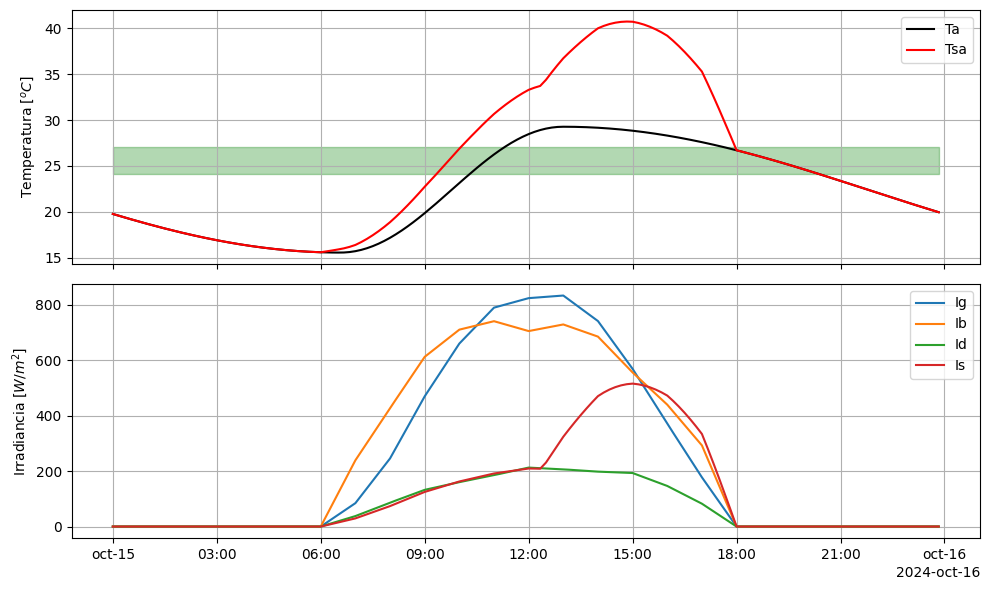

In [3]:
fig, ax = plt.subplots(2,figsize=(10,6),sharex=True)

df = dia.iloc[::600]
ax[0].plot(df.Ta, 'k-',label='Ta')
# ax[0].plot(df.Tn, 'g-',label='Tn')
ax[0].plot(df.Tsa,'r-',label='Tsa')
ax[0].fill_between(df.index,
                   df.Tn + df.DeltaTn,
                   df.Tn - df.DeltaTn,color='green',alpha=0.3)

ax[1].plot(df.Ig,label='Ig')
ax[1].plot(df.Ib,label='Ib')
ax[1].plot(df.Id,label='Id')
ax[1].plot(df.Is,label='Is')

ax[0].set_ylabel('Temperatura [$^oC$]')
ax[1].set_ylabel('Irradiancia [$W/m^2$]')

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)
ax[1].xaxis.set_major_formatter(formatter)


for a in ax:
    a.legend()
    a.grid()
fig.tight_layout()